In [15]:
import os
from os.path import join

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from shapely.geometry import Polygon, Point
import numpy as np
import xarray as xr
from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn

from torchvision.models import efficientnet_b0
import geopandas as gpd

import matplotlib.pyplot as plt

device = "cuda"

In [16]:
f_path = "/home/vannsh.jani/brick_kilns/githubrepo/ML/model_50_no_ssl_features_imagenet.pth"
c_path = "/home/vannsh.jani/brick_kilns/githubrepo/ML/model_50_no_ssl_classifier_imagenet.pth"

model = efficientnet_b0(pretrained=False)
model.classifier = nn.Linear(1280,2)
model.features.load_state_dict(torch.load(f_path))
model.classifier.load_state_dict(torch.load(c_path))
model.to(device)
model.eval();

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
gdf = gpd.read_file("/home/rishabh.mondal/Brick-Kilns-project/albk/experiments/data_preperation/shapefiles/statewise/DISTRICT_BOUNDARY.shp")
gdf.columns
gdf['District'] = gdf['District'].str.replace('>', 'A')
gdf['District'] = gdf['District'].str.replace('<', 'A')
gdf['STATE'] = gdf['STATE'].str.replace('>', 'A') 
gdf['STATE'] = gdf['STATE'].str.replace('<', 'A')

<Axes: >

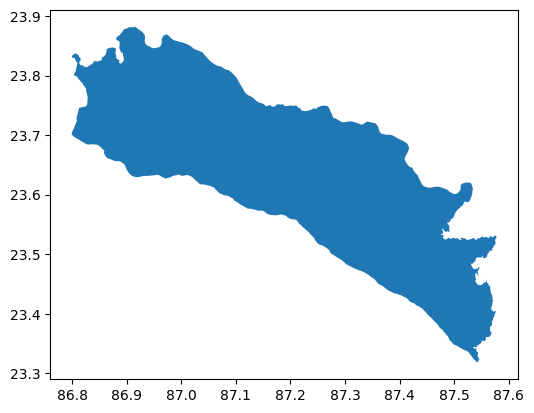

In [18]:
state_gdf = gdf[gdf['STATE'] == 'WEST BENGAL']
district = "PASCHIM BARDDHAMAN".upper()
custom_gdf = gdf[gdf["District"] == district]
state_gdf = state_gdf.to_crs(epsg=4326)
custom_gdf = custom_gdf.to_crs(epsg=4326)

custom_gdf.plot()

In [19]:
input_folder_path='/home/rishabh.mondal/bkdb/statewise/West_Bengal'
output_folder_path='/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive'
number_of_files_to_process = 10 
input_files = [os.path.join(input_folder_path, file) for file in os.listdir(input_folder_path) if file.endswith('.zarr')]
output_files = [os.path.join(output_folder_path, file) for file in os.listdir(output_folder_path) if file.endswith('.csv')]


In [25]:
import os
import sys
import torch
import xarray as xr
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# # Replace 'YourPyTorchModel' with the actual instantiation of your model
# model = YourPyTorchModel()  # Replace with the actual instantiation of your model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

def process_file(file):
    data = xr.open_zarr(file, consolidated=False)
    img_list = []
    idx_list = []
    for lat_lag in range(-2, 3):
        for lon_lag in range(-2, 3):
            img = data["data"].sel(lat_lag=lat_lag, lon_lag=lon_lag).values
            lat = data["lat"].values.item()
            lon = data["lon"].values.item()
            idx = f"{lat:.2f},{lon:.2f}_{lat_lag}_{lon_lag}"
            img = torch.tensor(img) / 255.0
            img = torch.einsum("hwc -> chw", img)
            img_list.append(img)
            idx_list.append(idx)
    return torch.stack(img_list), idx_list

def save_results(results, output_folder_path):
    df = pd.DataFrame(results, columns=['lat', 'lon', 'lat_lag', 'lon_lag', 'pred_proba', 'pred_label'])
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    output_csv_path = os.path.join(output_folder_path, 'results.csv')
    df.to_csv(output_csv_path, index=False)

def main():
    input_folder_path='/home/rishabh.mondal/bkdb/statewise/West_Bengal'
    output_folder_path='/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive'
    number_of_files_to_process = 45  # Set the desired number of files to process

    input_files = [os.path.join(input_folder_path, file) for file in os.listdir(input_folder_path) if file.endswith('.zarr')]
    output_files = [os.path.join(output_folder_path, file) for file in os.listdir(output_folder_path) if file.endswith('.csv')]

    files_to_process = [file for file in input_files if file not in output_files]

    if len(files_to_process) == 0:
        sys.exit("No files to process. Exiting.")

    # Use Parallel to process files in parallel
    results = Parallel(n_jobs=48)(delayed(process_file)(file) for file in tqdm(files_to_process[:number_of_files_to_process]))

    # Concatenate images and calculate mean and std
    all_images = torch.cat([result[0] for result in results], dim=0)
    mean = all_images.mean(dim=(0, 2, 3), keepdims=True)
    std = all_images.std(dim=(0, 2, 3), keepdims=True)
    all_images = (all_images - mean) / std

    # Flatten the list of indices
    all_idx = [idx for result in results for idx in result[1]]

    # Batched inference
    batch_size = 512
    all_preds = []

    for i in tqdm(range(0, len(all_images), batch_size)):
        batch = all_images[i:i + batch_size].to(device)
        with torch.no_grad():
            preds = model(batch).argmax(dim=1).cpu()
        all_preds.append(preds)

    # Concatenate predictions
    all_preds = torch.cat(all_preds, dim=0)
    print(all_preds)

    # # Save results to a CSV file                                      #### error lines
    # save_results(list(zip(all_idx, all_preds)), output_folder_path)   #### error lines
    pred_positive_idx = (all_preds == 1)
    print(pred_positive_idx.sum())
if __name__ == "__main__":
    main()


100%|██████████| 45/45 [00:00<00:00, 42271.82it/s]


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]

tensor([0, 0, 0,  ..., 0, 0, 0])
tensor(1)
